In [158]:
# Proof of concept
# Solving the GT problem as a purely timeseries problem and not as a graph time-series problem (using ARIMA model)
# Here, we ignore the structural aspects of the graph
# We treat each edge weight as a signal and see how it evolves over time. 
# We observe from [1, 4000] time steps for each edge and predict for future [4001, 4210] steps

# refers to the following files from the dataset here: https://gitlab.datadrivendiscovery.org/d3m/datasets/tree/master/seed_datasets_current/LL1_GT_actor_group_association_prediction_MIN_METADATA/LL1_GT_actor_group_association_prediction_MIN_METADATA_dataset
# 1. tables/learningData.csv
# 2. graphs/edgeList.csv

In [64]:
import os, json
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.iolib.smpickle import load_pickle, save_pickle
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import numpy, random
from collections import OrderedDict
warnings.filterwarnings('ignore')

In [65]:
DATA_DIR = os.path.join('../../d3m_shared/GT-datasets/problem1')
ENDO_VAR = 'association_strength'
train_timesteps_min = 1
train_timesteps_max = 3999
test_timesteps_min = 4000
test_timesteps_max = 4210

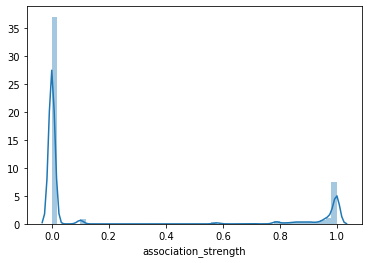

In [66]:
df = pd.read_csv(os.path.join(DATA_DIR, 'learningData.csv'))
sns.distplot(df['association_strength'])

In [71]:
non_zero_df = df.loc[~(df[['association_strength']]==0).all(axis=1)]
print(non_zero_df.shape)
display(non_zero_df.head(), non_zero_df.tail())

(4357, 4)


,d3mIndex,timestep,edgeID,association_strength
0,0,1,0,1.000000
2,2,1,2,0.997244
8,8,1,8,0.973161
9,9,1,9,0.950397
10,10,1,10,1.000000


,d3mIndex,timestep,edgeID,association_strength
16702,16702,4210,217,0.989705
16703,16703,4210,218,0.985103
16704,16704,4210,219,1.000000
16705,16705,4210,220,0.937773
16706,16706,4210,221,0.988061


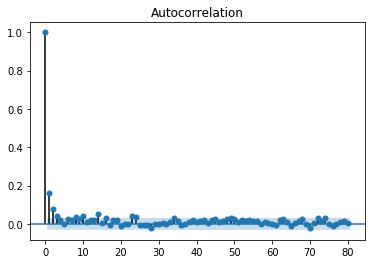

In [83]:
stld_plot  = plot_acf(non_zero_df['association_strength'].values.squeeze(), lags=80)

In [157]:
# join the learningData and edgeList data into a consolidated table

enable_preprocess = False

if enable_preprocess:
    df = pd.read_csv(os.path.join(DATA_DIR, 'learningData.csv'))
    print(df.shape)
    print('(unique, min and max) time steps:', len(df['timestep'].unique()), df['timestep'].min(), df['timestep'].max())
    
    edges = pd.read_csv(os.path.join(DATA_DIR, 'edgeList.csv'))
    print(edges.shape)
    print('min and max edgeIDs:', edges['edgeID'].min(), edges['edgeID'].max())
    print("---------------")
    
    mddfs = []
    for i, t in enumerate(df.timestep.unique()):
        lddf = df[df.timestep==t][['timestep', 'edgeID', 'association_strength']]
        lddf.drop_duplicates(subset='edgeID', inplace=True)
        eddf = edges[['edgeID']]
        mddf = lddf.merge(right=eddf, on='edgeID', how='outer')
        mddf = mddf.drop_duplicates(keep='last')
        # display(mddf.head(), mddf.tail())
        mddf['timestep']=[t]*len(mddf)
        mddf = mddf.fillna(0.0)
        mddfs.append(mddf)
    
    bigdf = pd.concat(mddfs, axis=0)
    bigdf.to_csv('timeseries.csv', index=None)
    print(bigdf.shape)
    

In [134]:
df = pd.read_csv('timeseries.csv')
print(df.shape)
print('unique edgeIDs', len(df['edgeID'].unique()))
print('(min and max) time steps', (df['timestep'].min(), df['timestep'].max()))
print('num of unique timesteps in edgeID groups', df.groupby('edgeID').count()['timestep'].unique())

(827442, 3)
unique edgeIDs 462
(min and max) time steps (1, 4210)
num of unique timesteps in edgeID groups [1791]


In [135]:
train_data = df[df['timestep'] < 4000]
test_data = df[df['timestep'] >= 4000]
print(train_data.shape, test_data.shape)
display(train_data.tail(), test_data.tail())

(784938, 3) (42504, 3)


,timestep,edgeID,association_strength
784933,3998,457,0.0
784934,3998,458,0.0
784935,3998,459,0.0
784936,3998,460,0.0
784937,3998,461,0.0


,timestep,edgeID,association_strength
827437,4210,457,0.0
827438,4210,458,0.0
827439,4210,459,0.0
827440,4210,460,0.0
827441,4210,461,0.0


In [136]:
enable_fit = False

if enable_fit:
    fitted_models = {}
    for edgeID in df['edgeID'].unique():
        print(edgeID, end=',')
        x_train = train_data[train_data['edgeID']==edgeID]['association_strength']
        x_test = test_data[test_data['edgeID']==edgeID]['association_strength']
        x_train.index = train_data[train_data['edgeID']==edgeID]['timestep']
        x_test.index = test_data[test_data['edgeID']==edgeID]['timestep']

        history_endo = [x for x in x_train]
        # add a small noise to history_endo1 (to avoid constant and invariancy exceptions)
        mu, sigma = 0, 0.01
        rng = np.random.RandomState(42)
        noise = rng.normal(mu, sigma, len(history_endo))
        history_endo += noise

        predictions = list()
        for i, t in enumerate(x_test.index.values):
            model = ARIMA(history_endo, order=(1,1,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast(steps=1)
            yhat = output[0][0]
            yhat = np.where(yhat<0, 0, yhat)
            predictions.append(yhat)
            obs = x_test[t]
            history_endo = np.append(history_endo, obs)
            # print(i, 'predicted=%f, expected=%f' % (yhat, obs))
            fitted_models[edgeID] = model_fit
    save_pickle(fitted_models, 'fitted_models.pickle')

In [137]:
fitted_models = load_pickle('fitted_models.pickle')

In [138]:
test_predictions = []
for edgeID in df['edgeID'].unique():
    print(edgeID, end=',')
    x_test = test_data[test_data['edgeID']==edgeID]['association_strength']
    x_test.index = test_data[test_data['edgeID']==edgeID]['timestep']
    
    model_fit = fitted_models[edgeID]
    output = model_fit.forecast(steps=len(x_test))
    yhat = output[0]
    yhat = np.where(yhat<0, 0, yhat)
    yhat_df = pd.DataFrame(yhat, columns=['pred_value'])
    yhat_df['edgeID'] = [edgeID]*len(yhat_df)
    yhat_df.index = x_test.index
    test_predictions.append(yhat_df)

test_predictions_df = pd.concat(test_predictions)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [153]:
# scoring on full test data
score_df = test_data.merge(right=test_predictions_df, on=['timestep', 'edgeID'], how='inner')
score_df.reset_index(inplace=True, drop=True)
print(score_df.shape)
display(score_df.head())

(42504, 4)


,timestep,edgeID,association_strength,pred_value
0,4000,308,0.000000,0.0
1,4000,309,0.000000,0.0
2,4000,310,0.000000,0.0
3,4000,311,0.000000,0.0
4,4000,312,0.814388,0.0


In [142]:
rmse = sqrt(mean_squared_error(score_df[ENDO_VAR], score_df['pred_value']))
rmse

0.08625224401298885

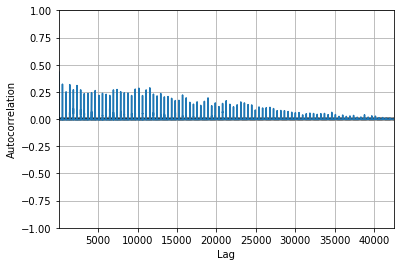

In [143]:
autocorrelation_plot(score_df['association_strength'])

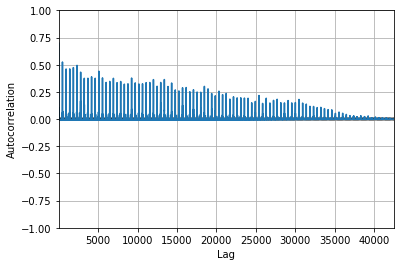

In [144]:
autocorrelation_plot(score_df['pred_value'])

In [147]:
# scoring only on non-zero values in test data
score_df = score_df.loc[~(score_df[['association_strength', 'pred_value']]==0).all(axis=1)]
display(score_df.head())

,index,timestep,edgeID,association_strength,pred_value
4,4,4000,312,0.814388,0.000000
8,8,4000,428,1.000000,0.000000
50,50,4000,36,0.000000,0.456430
51,51,4000,37,0.000000,0.414648
52,52,4000,38,0.000000,0.501126


In [148]:
rmse = sqrt(mean_squared_error(score_df[ENDO_VAR], score_df['pred_value']))
rmse

0.6084940962755011

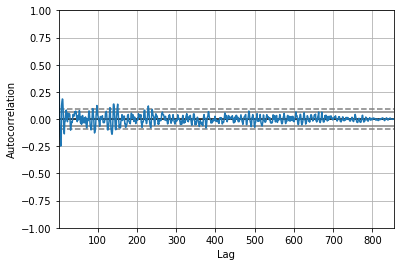

In [149]:
autocorrelation_plot(score_df['association_strength'])

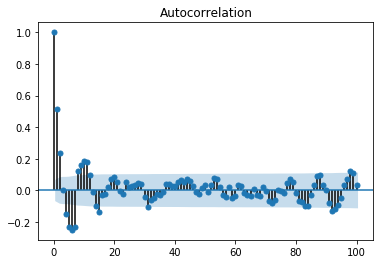

In [151]:
stld_plot  = plot_acf(score_df['association_strength'].values.squeeze(), lags=100)

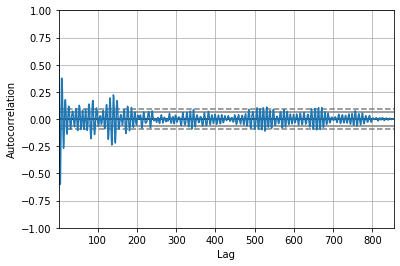

In [150]:
autocorrelation_plot(score_df['pred_value'])

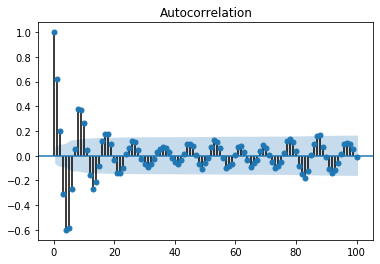

In [152]:
stld_plot  = plot_acf(score_df['pred_value'].values.squeeze(), lags=100)